In [19]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [20]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import  transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

cuda


Take all the image data into a single Pandas dataframe

In [21]:
DATASET_PATH = "/content/animal-faces/afhq"

image_path = []
labels = []

for i in os.listdir(DATASET_PATH):
  for label in os.listdir(f"{DATASET_PATH}/{i}"):
    for image in os.listdir(f"{DATASET_PATH}/{i}/{label}"):
      image_path.append(f"{DATASET_PATH}/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame({"image_path": image_path, "labels": labels})
data_df.head()

,image_path,labels
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/flickr_do...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


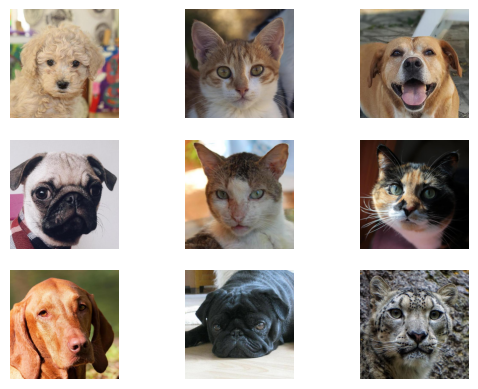

In [22]:
f, axarr = plt.subplots(3,3)

for row in range(3):
  for col in range(3):
    image = Image.open(data_df.sample(n=1)['image_path'].iloc[0]).convert('RGB')
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')

plt.show()

## Creating the test train validation split
Training   = 70%
Test       = 15%
Validation = 15%



In [23]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)

val = test.sample(frac=0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(11291, 2)
(2419, 2)
(2420, 2)


In [24]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
  ])

In [25]:
class CustomImageDataset(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(df['labels'])).to(device)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    img_path = self.df.iloc[idx, 0]
    label = self.labels[idx] # Corrected indexing
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image).to(device)

    return image, label

In [26]:
train_dataset = CustomImageDataset(train, transform=transform)
test_dataset = CustomImageDataset(test, transform=transform)
val_dataset = CustomImageDataset(val, transform=transform)

### Hyperparameters

In [27]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [28]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model design

In [29]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2,2)

    self.relu = nn.ReLU()

    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16), 128)

    self.output = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x)     # -> 32, 128, 128
    x = self.pooling(x)   # -> 32, 64, 64
    x = self.relu(x)

    x = self.conv2(x)     # -> 64, 64, 64
    x = self.pooling(x)   # -> 64, 32, 32
    x = self.relu(x)

    x = self.conv3(x)     # -> 128, 32, 32
    x = self.pooling(x)   # -> 128, 16, 16
    x = self.relu(x)

    x = self.flatten(x)
    x = self.linear(x)    # -> 128*16*16, 128
    x = self.output(x)    # -> 128, 3

    return x

In [30]:
model = NeuralNet().to(device)

In [31]:
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

# TRAINING and VALIDATION

In [33]:
total_loss_train_plot = []
total_acc_train_plot = []
total_loss_val_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
  total_train_loss = 0.0
  total_train_acc = 0.0
  total_val_loss = 0.0
  total_val_acc = 0.0

  for input, labels in train_loader:
    optimizer.zero_grad()

    outputs = model(input)
    train_loss = criterion(outputs, labels)
    total_train_loss += train_loss.item()

    train_loss.backward()
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_train_acc += train_acc

    optimizer.step()

  with torch.no_grad():
    for input, labels in val_loader:
      outputs = model(input)
      val_loss = criterion(outputs, labels)
      total_val_loss += val_loss.item()

      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_val_acc += val_acc

  total_loss_train_plot.append(round(total_train_loss / 1000, 4))
  total_acc_train_plot.append(round((total_train_acc / train_dataset.__len__())*100, 4))

  total_loss_val_plot.append(round(total_val_loss / 1000, 4))
  total_acc_val_plot.append(round((total_val_acc / val_dataset.__len__())*100, 4))

  print(f'''Epoch {epoch+1} : Train Loss = {round(total_train_loss / 1000, 4)} Train Accuracy = {round((total_train_acc / train_dataset.__len__())*100, 4)}
        Validation Loss = {round(total_val_loss / 1000, 4)} Validation Accuracy = {round((total_val_acc / val_dataset.__len__())*100, 4)}''')



Epoch 1 : Train Loss = 0.3352 Train Accuracy = 80.1612
        Validation Loss = 0.0423 Validation Accuracy = 90.2479
Epoch 2 : Train Loss = 0.1392 Train Accuracy = 92.959
        Validation Loss = 0.0291 Validation Accuracy = 93.1818
Epoch 3 : Train Loss = 0.0906 Train Accuracy = 95.3946
        Validation Loss = 0.0211 Validation Accuracy = 94.876
Epoch 4 : Train Loss = 0.0627 Train Accuracy = 96.7496
        Validation Loss = 0.0161 Validation Accuracy = 96.157
Epoch 5 : Train Loss = 0.0458 Train Accuracy = 97.6619
        Validation Loss = 0.0164 Validation Accuracy = 96.157
Epoch 6 : Train Loss = 0.0314 Train Accuracy = 98.4324
        Validation Loss = 0.0216 Validation Accuracy = 95.5372
Epoch 7 : Train Loss = 0.0266 Train Accuracy = 98.7866
        Validation Loss = 0.0152 Validation Accuracy = 96.4463
Epoch 8 : Train Loss = 0.0163 Train Accuracy = 99.2295
        Validation Loss = 0.0174 Validation Accuracy = 96.5289
Epoch 9 : Train Loss = 0.013 Train Accuracy = 99.442
       

# TESTING

In [35]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in test_loader:
    outputs = model(inputs)
    test_loss = criterion(outputs, labels)
    total_loss_test += test_loss.item()

    test_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_test += test_acc

print(f"Train Loss = {round(total_loss_test / 1000, 4)} Train Accuracy = {round((total_acc_test / test_dataset.__len__())*100, 4)} ")

Train Loss = 0.0182 Train Accuracy = 95.9901 


# PLOTTING

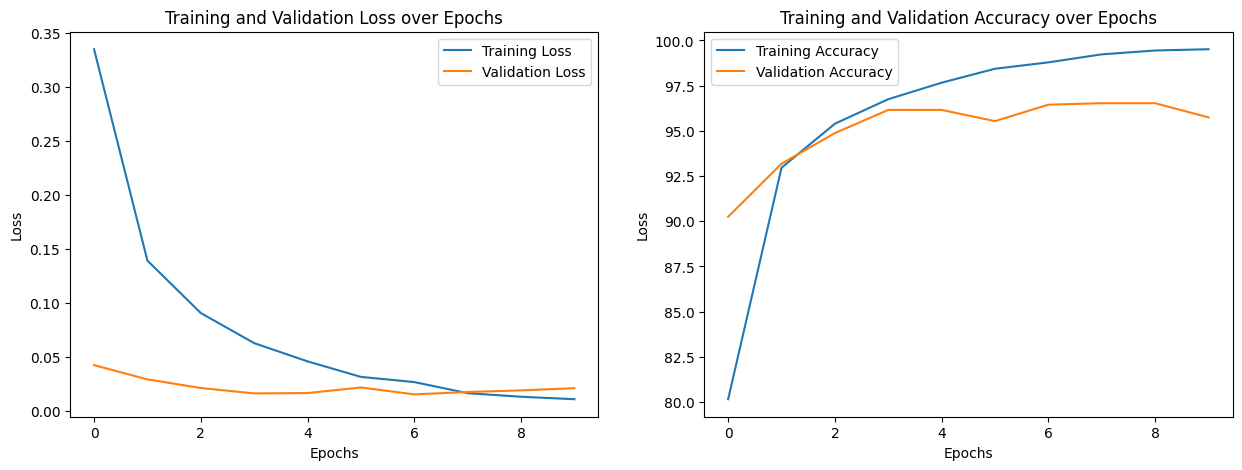

In [41]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_val_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()


axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_val_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()

plt.show()

# INFERENCE

In [46]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)
  print(image.shape)
  prediction = model(image.unsqueeze(0))
  output = torch.argmax(prediction, axis=1).item()

  return label_encoder.inverse_transform([output])


In [47]:
IMAGE_PATH = "/content/kitty-cat-kitten-pet-45201.jpeg"
predict_image(IMAGE_PATH)

torch.Size([3, 128, 128])


array(['wild'], dtype=object)